In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import torch
import random
from glob import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset

seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

%matplotlib inline

In [3]:
path = '/content/drive/MyDrive/data/programmers_ai/mlops/COVID_19_XRAY_2/'

In [4]:
train = pd.read_csv(os.path.join(path, 'train/labels.csv'))
train.head

<bound method NDFrame.head of             filename   label
0      image_001.png   covid
1      image_002.png   covid
2      image_003.png  normal
3      image_004.png  normal
4      image_005.png  normal
...              ...     ...
1995  image_1996.png   covid
1996  image_1997.png  normal
1997  image_1998.png   covid
1998  image_1999.png  normal
1999  image_2000.png  normal

[2000 rows x 2 columns]>

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2000 non-null   object
 1   label     2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [6]:
label_encoding = {'normal': 0, 'covid': 1}
train['label'] = train['label'].apply(lambda x: label_encoding[x])

In [9]:
train, valid = train_test_split(train, test_size=0.1, stratify=train['label'], random_state=34)

In [10]:
train.shape, valid.shape

((1800, 2), (200, 2))

In [11]:
train.head()

,filename,label
1938,image_1939.png,0
444,image_445.png,1
1843,image_1844.png,1
1666,image_1667.png,0
106,image_107.png,0


In [12]:
train.iloc[0, 0]

'image_1939.png'

In [13]:
image = cv2.imread(os.path.join(path, 'train/image_1964.png'))
image.shape

(299, 299, 3)

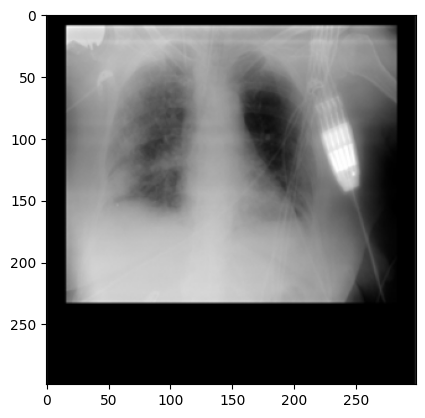

In [14]:
plt.imshow(image)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

## 데이터셋 클래스 정의

In [16]:
class ImageDataset(Dataset):
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id
        image = cv2.imread(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image
        else:
            label = self.df.iloc[idx, 1]
            return image, label

## 이미지 변환기 정의

In [27]:
from torchvision import transforms

# 훈련 데이터용 변환기
transform_train = transforms.Compose([
                          transforms.ToPILImage(),
                          transforms.Resize((224, 224)),      # 이미지 크기 조정 
                          transforms.CenterCrop(180),         # 중앙 이미지 확대
                          transforms.RandomHorizontalFlip(0.5), # 좌우 대칭
                          transforms.RandomVerticalFlip(0.2), # 상하 대칭
                          transforms.RandomRotation(20),      # 이미지 회전
                          transforms.ToTensor(),              # 텐서 객체로 변환
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))]) # 정규화

# 테스트 데이터용 변환기
transform_test = transforms.Compose([
                          transforms.ToPILImage(),
                          transforms.Resize((224, 224)),
                          transforms.CenterCrop(180),
                          transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))])

## 데이터셋 및 데이터 로더 생성

In [28]:
dataset_train = ImageDataset(train, img_dir=os.path.join(path,'train/'), transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=os.path.join(path, 'train/'), transform=transform_test)

In [29]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [30]:
from torch.utils.data import DataLoader

batch_size = 10

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=2)

In [31]:
!pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from efficientnet_pytorch import EfficientNet

In [33]:
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=2)
model = model.to(device)

Loaded pretrained weights for efficientnet-b7


In [34]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [35]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

In [40]:
from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score 
from tqdm.notebook import tqdm
epochs = 10

for epoch in range(epochs):
    # 훈련
    model.train() # 모델을 훈련 상태로 설정
    epoch_train_loss = 0 # 에폭별 손실값 초기화(훈련 데이터용)
    
    for images, labels in tqdm(loader_train):
      images = images.to(device)
      labels = labels.to(device)
        
      optimizer.zero_grad() # 옵티마이저 내 기울기 초기화
      outputs = model(images) # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
      loss = criterion(outputs, labels) # 손실 함수를 활용해 outputs와 labels의 손실값 계산
      epoch_train_loss += loss.item() # 현제 배치에서 손실 추가(훈련 데이터용)
      loss.backward() # 역전파 수행
      optimizer.step() # 가중치 갱신
    print(f'에폭 {epoch + 1}/{epochs} - 훈련 데이터 손실값: {epoch_train_loss / len(loader_train): .4f}')
    
    # 검증
    model.eval() # 모델을 평가 상태로 설정
    epoch_valid_loss = 0 # 에폭별 손실값 초기화(검증 데이터 용)
    preds_list = [] # 예측 확률값 저장용 리스트 초기화
    true_list = [] # 실제 타깃값 저장용 리스트 초기화
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.max(outputs.cpu(), dim=1)[1].numpy() 
            true = labels.cpu().numpy() 

            preds_list.extend(preds)
            true_list.extend(true)
    # 정확도, 재현율, F1 점수 계산
    val_accuracy = accuracy_score(true_list, preds_list)
    val_recall = recall_score(true_list, preds_list)
    val_f1_score = f1_score(true_list, preds_list)

    # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
    print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
    print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')

  0%|          | 0/180 [00:00<?, ?it/s]

에폭 1/10 - 훈련 데이터 손실값:  0.2283
	검증 데이터 손실값 : 0.2441
	정확도 : 0.9100 / 재현율 : 0.8800 / F1 점수 : 0.9072


  0%|          | 0/180 [00:00<?, ?it/s]

에폭 2/10 - 훈련 데이터 손실값:  0.2184
	검증 데이터 손실값 : 0.2239
	정확도 : 0.9250 / 재현율 : 0.9500 / F1 점수 : 0.9268


  0%|          | 0/180 [00:00<?, ?it/s]

에폭 3/10 - 훈련 데이터 손실값:  0.2051
	검증 데이터 손실값 : 0.1556
	정확도 : 0.9400 / 재현율 : 0.9500 / F1 점수 : 0.9406


  0%|          | 0/180 [00:00<?, ?it/s]

에폭 4/10 - 훈련 데이터 손실값:  0.1573
	검증 데이터 손실값 : 0.1475
	정확도 : 0.9450 / 재현율 : 0.9300 / F1 점수 : 0.9442


  0%|          | 0/180 [00:00<?, ?it/s]

에폭 5/10 - 훈련 데이터 손실값:  0.1457
	검증 데이터 손실값 : 0.1284
	정확도 : 0.9500 / 재현율 : 0.9700 / F1 점수 : 0.9510


  0%|          | 0/180 [00:00<?, ?it/s]

에폭 6/10 - 훈련 데이터 손실값:  0.1129
	검증 데이터 손실값 : 0.1784
	정확도 : 0.9500 / 재현율 : 0.9100 / F1 점수 : 0.9479


  0%|          | 0/180 [00:00<?, ?it/s]

에폭 7/10 - 훈련 데이터 손실값:  0.1295
	검증 데이터 손실값 : 0.1284
	정확도 : 0.9450 / 재현율 : 0.9800 / F1 점수 : 0.9469


  0%|          | 0/180 [00:00<?, ?it/s]

에폭 8/10 - 훈련 데이터 손실값:  0.1243
	검증 데이터 손실값 : 0.1235
	정확도 : 0.9600 / 재현율 : 0.9500 / F1 점수 : 0.9596


  0%|          | 0/180 [00:00<?, ?it/s]

에폭 9/10 - 훈련 데이터 손실값:  0.0971
	검증 데이터 손실값 : 0.0915
	정확도 : 0.9650 / 재현율 : 0.9700 / F1 점수 : 0.9652


  0%|          | 0/180 [00:00<?, ?it/s]

에폭 10/10 - 훈련 데이터 손실값:  0.0925
	검증 데이터 손실값 : 0.1104
	정확도 : 0.9450 / 재현율 : 0.9900 / F1 점수 : 0.9474


## test 및 제출

In [42]:
submission = pd.read_csv(os.path.join(path,'submission.csv'))
submission.head()

,filename,label
0,image_001.png,NaN
1,image_002.png,NaN
2,image_003.png,NaN
3,image_004.png,NaN
4,image_005.png,NaN


In [43]:
dataset_test = ImageDataset(submission, img_dir=os.path.join(path,'test/'), transform=transform_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=2)

In [50]:
model.eval()

preds_list = []

with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        preds = torch.max(outputs.cpu(), dim=1)[1].numpy()
        preds_list.extend(preds)

In [52]:
preds_list[:10]

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1]

In [53]:
info = {0: 'normal', 1:'covid'}

preds_list =list(map(lambda x: info[x], preds_list))
preds_list[:10]

['covid',
 'covid',
 'covid',
 'covid',
 'normal',
 'normal',
 'covid',
 'covid',
 'covid',
 'covid']

In [54]:
submission['label'] = preds_list

In [57]:
submission.to_csv('submission.csv',index=False)

In [56]:
submission.head()

,filename,label
0,image_001.png,covid
1,image_002.png,covid
2,image_003.png,covid
3,image_004.png,covid
4,image_005.png,normal
